In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar  6 01:13:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing dependencies 

In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from zipfile import ZipFile
from google.colab.patches import cv2_imshow
from skimage import io 

## Unzip File

In [3]:
#with ZipFile('/content/drive/MyDrive/Dataset.zip','r') as zip:
  #zip.extractall('/content/drive/MyDrive/Image Segmentation')

## Loading Data 

### Loading the train folder

In [4]:
# path to the train directory
path = "/content/drive/MyDrive/Image Segmentation/cityscapes_data/train/"
# creating a list of the images inside train folder
train_images = os.listdir(path)
number = 1000
subset_train_images = train_images[0:number]
# number of images inside the training folder
print('Train directory has {} images.'.format(len(train_images)))
print('After taking a subset, the train directory now has {} images.'.format(len(subset_train_images)))

Train directory has 2975 images.
After taking a subset, the train directory now has 1000 images.


### Loading the validation folder

In [5]:
# path to the validation(val) directory
path1 = "/content/drive/MyDrive/Image Segmentation/cityscapes_data/val/"
# creating a list of the images inside validation directory
val_images = os.listdir(path1)
# number of images inside the validation folder
print('Validation directory has {} images.'.format(len(val_images)))

Validation directory has 500 images.


## Visualizing Data

In [6]:
def show_image (pathname, image_list, idx):
  # reading the first image from the folder
  image = io.imread(pathname + image_list[idx],0)
  # dimensions of the image
  print('This below image has the following properties:{}'.format(np.shape(image)))
  #displaying the image
  cv2_imshow(image)

This below image has the following properties:(256, 512, 3)


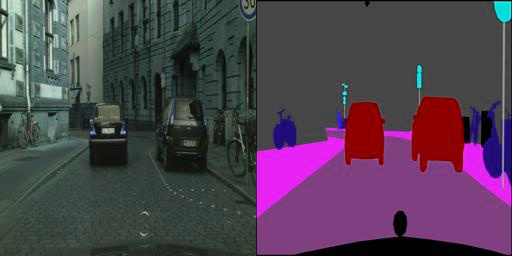

In [7]:
train_image = show_image(path, subset_train_images,0)

This below image has the following properties:(256, 512, 3)


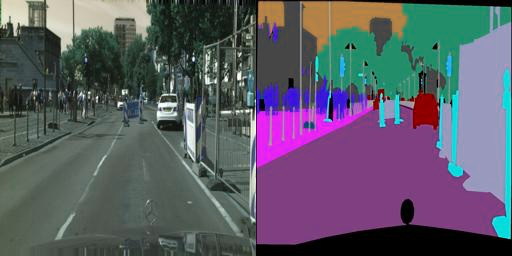

In [8]:
val_image = show_image(path1, val_images,0)

## Preprocessing Data 

In [9]:
idx = 0
image = io.imread(path + subset_train_images[idx])
height,width, _ = np.shape(image)
# number of images in the folder
N_images = len(subset_train_images)
imgs_train = np.zeros((N_images,height,int(width/2),3))
masks_train = np.zeros((N_images,height,int(width/2),3))
k = 0;
# looping through each original to split it
for i in subset_train_images [0:N_images]:
  # obtaining the image
  imgs_train[k] = cv2.imread(path + i)[:,:256]/256
  # obtaining the mask 
  masks_train[k] = cv2.imread(path + i)[:,256:]/256
  k = k + 1
  



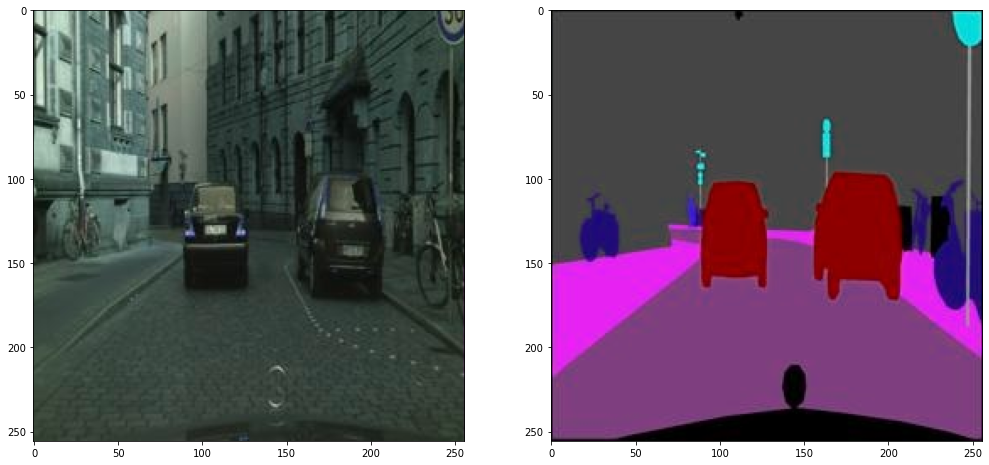

In [10]:
plt.figure(figsize = (17,17))
# plotting the image
plt.subplot (1,2,1)
plt.imshow(imgs_train[0])
# plotting the mask
plt.subplot(1,2,2)
plt.imshow(masks_train[0])

In [11]:
idx = 0
image1 = io.imread(path1 + val_images[idx])
height,width, _ = np.shape(image1)
# number of images in the folder
N_images = len(val_images)
imgs_val = np.zeros((N_images,height,int(width/2),3))
masks_val = np.zeros((N_images,height,int(width/2),3))
z = 0;

# looping through each original to split it
for i in val_images [0:N_images]:
  # obtaining the image
  imgs_val[z] = cv2.imread(path1 + i)[:,:256]/256
  # obtaining the mask 
  masks_val[z] = cv2.imread(path1 + i)[:,256:]/256
  z = z + 1

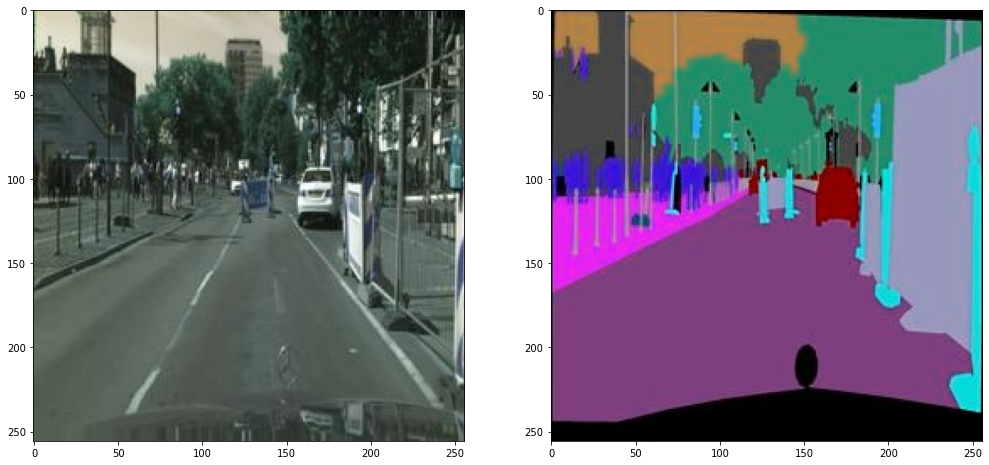

In [12]:
plt.figure(figsize = (17,17))
# plotting the image
plt.subplot (1,2,1)
plt.imshow(imgs_val[0])
# plotting the mask
plt.subplot(1,2,2)
plt.imshow(masks_val[0])

In [13]:
# check if need to normalize 
masks_val.dtype

dtype('float64')

In [14]:
print(imgs_train.shape)
print(masks_train.shape)
print(imgs_val.shape)
print(masks_val.shape)

(1000, 256, 256, 3)
(1000, 256, 256, 3)
(500, 256, 256, 3)
(500, 256, 256, 3)


## Define the model 

Building U-Net using encoder and decoder blocks

Building encoder and decoder blocks 

In [15]:
# Building Unet using encoder and decoder blocks
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D,  concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate

#pip install focal-loss
#from focal-loss  import CategoricalFocalLoss

# will increase the conv layers to see if it affects the output
def conv_block(input, num_filters=64):
  # first conv layer
  x = Conv2D(num_filters, kernel_size = (3,3), padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # second conv layer
  x = Conv2D(num_filters, kernel_size= (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

def encoder_block(input, num_filters=64):
  # conv block
  x = conv_block(input,num_filters)
  # maxpooling 
  p = MaxPool2D(strides = (2,2))(x)
  p = Dropout(0.4)(p)
  return x,p

def decoder_block(input, skip_features, num_filters=64):
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x




Building UNet Architecture 

In [16]:
def unet_architect(input_shape=(256,256,3)):

  """ Input Layer """
  inputs = Input(input_shape)

  """ Encoder """
  s1,p1 = encoder_block(inputs, 64)
  s2,p2 = encoder_block(p1,128)
  s3,p3 = encoder_block(p2, 256)
  s4,p4 = encoder_block(p3, 512)

  """ Bridge """
  b1 = conv_block(p4,1024)

  """ Decoder """ 
  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  """ Output Layer """
  outputs = Conv2D(7, (1,1), padding='same', activation = 'softmax')(d4)

  model = Model(inputs, outputs, name='U-Net')

  return model

In [17]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
model = unet_architect()
#lr = 0.0001, # 0.001, 0.01, 0.1
model.compile(optimizer = 'adam' , 
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
# try focal loss function for loss
model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [18]:
unet_model =  model.fit(imgs_train, masks_train, batch_size = 15, epochs = 15, shuffle = True, validation_data = (imgs_val,masks_val))

Epoch 1/15


InvalidArgumentError: ignored

In [ ]:
predictions = model.predict (imgs_val[0:20,:,:,:])

In [ ]:
# predictions on first n images
n_pred_img = 5
for n in range(n_pred_img):
  
  plt.figure(figsize=(15,30))
  plt.subplot(n_pred_img, 3, 1+n*3)
  plt.title('Original Image')
  plt.imshow(imgs_val[n])
  plt.subplot(n_pred_img, 3, 2+n*3)
  plt.title('Masked Image')
  plt.imshow(masks_val[n])
  plt.subplot(n_pred_img, 3, 3+n*3)
  plt.title('Predicted Image')
  plt.imshow(predictions[n]) 
  